In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

resultsPath = Path("../results/MPI_9.csv")


In [2]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["messageSizeBytes"] = dataFrame["messageSizeBytes"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["customTime"] = dataFrame["customTime"].astype(float)
dataFrame["mpiTime"] = dataFrame["mpiTime"].astype(float)
dataFrame["checksum"] = dataFrame["checksum"].astype(object)

print("Rows:", len(dataFrame))
print("Ops:", dataFrame["opName"].unique())
print("Sizes:", sorted(dataFrame["messageSizeBytes"].unique()))
print("Procs:", sorted(dataFrame["numProcesses"].unique()))


Rows: 630
Ops: ['bcast' 'reduce' 'scatter' 'gather' 'allgather' 'alltoall']
Sizes: [1, 16, 1024, 16384, 65536, 262144, 1048576]
Procs: [1, 2, 4, 8, 16]


In [3]:
grouped = dataFrame.groupby(["opName","messageSizeBytes","numProcesses"], as_index=False).agg(
    medianCustom = ("customTime","median"),
    medianMpi    = ("mpiTime","median"),
    stdCustom    = ("customTime","std"),
    stdMpi       = ("mpiTime","std"),
    count        = ("customTime","count")
)
grouped["stdCustom"] = grouped["stdCustom"].fillna(0.0)
grouped["stdMpi"] = grouped["stdMpi"].fillna(0.0)
grouped = grouped.sort_values(["opName","messageSizeBytes","numProcesses"]).reset_index(drop=True)
grouped.head(12)


,opName,messageSizeBytes,numProcesses,medianCustom,medianMpi,stdCustom,stdMpi,count
0,allgather,1,1,9.800000e-08,1.640000e-07,4.725816e-09,4.041452e-09,3
1,allgather,1,2,6.730000e-07,5.190000e-07,9.775650e-08,4.743768e-08,3
2,allgather,1,4,1.957000e-06,1.331000e-06,2.384834e-07,6.848601e-08,3
3,allgather,1,8,3.626000e-06,2.461000e-06,4.419276e-08,2.145328e-07,3
4,allgather,1,16,5.590000e-06,3.833000e-06,1.836410e-07,8.753856e-08,3
5,allgather,16,1,9.400000e-08,1.640000e-07,1.789786e-08,2.914332e-08,3
6,allgather,16,2,7.810000e-07,5.230000e-07,1.639909e-07,2.351595e-08,3
7,allgather,16,4,2.167000e-06,1.411000e-06,5.197115e-08,3.635015e-08,3
8,allgather,16,8,3.798000e-06,2.687000e-06,4.050926e-08,2.855387e-07,3
9,allgather,16,16,7.045000e-06,5.283000e-06,1.466026e-07,2.742432e-07,3


In [4]:
def computeSpeedupEfficiencyForMedian(baseGrouped, medianColName, stdColName):
    frames = []
    for (opVal, messageSizeVal), subFrame in baseGrouped.groupby(["opName","messageSizeBytes"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows[medianColName].values[0])
        subFrame = subFrame.copy()
        subFrame = subFrame.assign(median = subFrame[medianColName].astype(float))
        if stdColName in subFrame.columns:
            subFrame["std"] = subFrame[stdColName].astype(float).fillna(0.0)
        else:
            subFrame["std"] = 0.0
        subFrame["speedup"] = np.where(subFrame["median"] > 0, baseTime / subFrame["median"], np.nan)
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numProcesses"]
        frames.append(subFrame)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrameCustom = computeSpeedupEfficiencyForMedian(grouped, "medianCustom", "stdCustom")
perfFrameMpi    = computeSpeedupEfficiencyForMedian(grouped, "medianMpi",    "stdMpi")

print("perfFrameCustom rows:", len(perfFrameCustom))
print("perfFrameMpi rows:", len(perfFrameMpi))

perfFrameCustom rows: 210
perfFrameMpi rows: 210


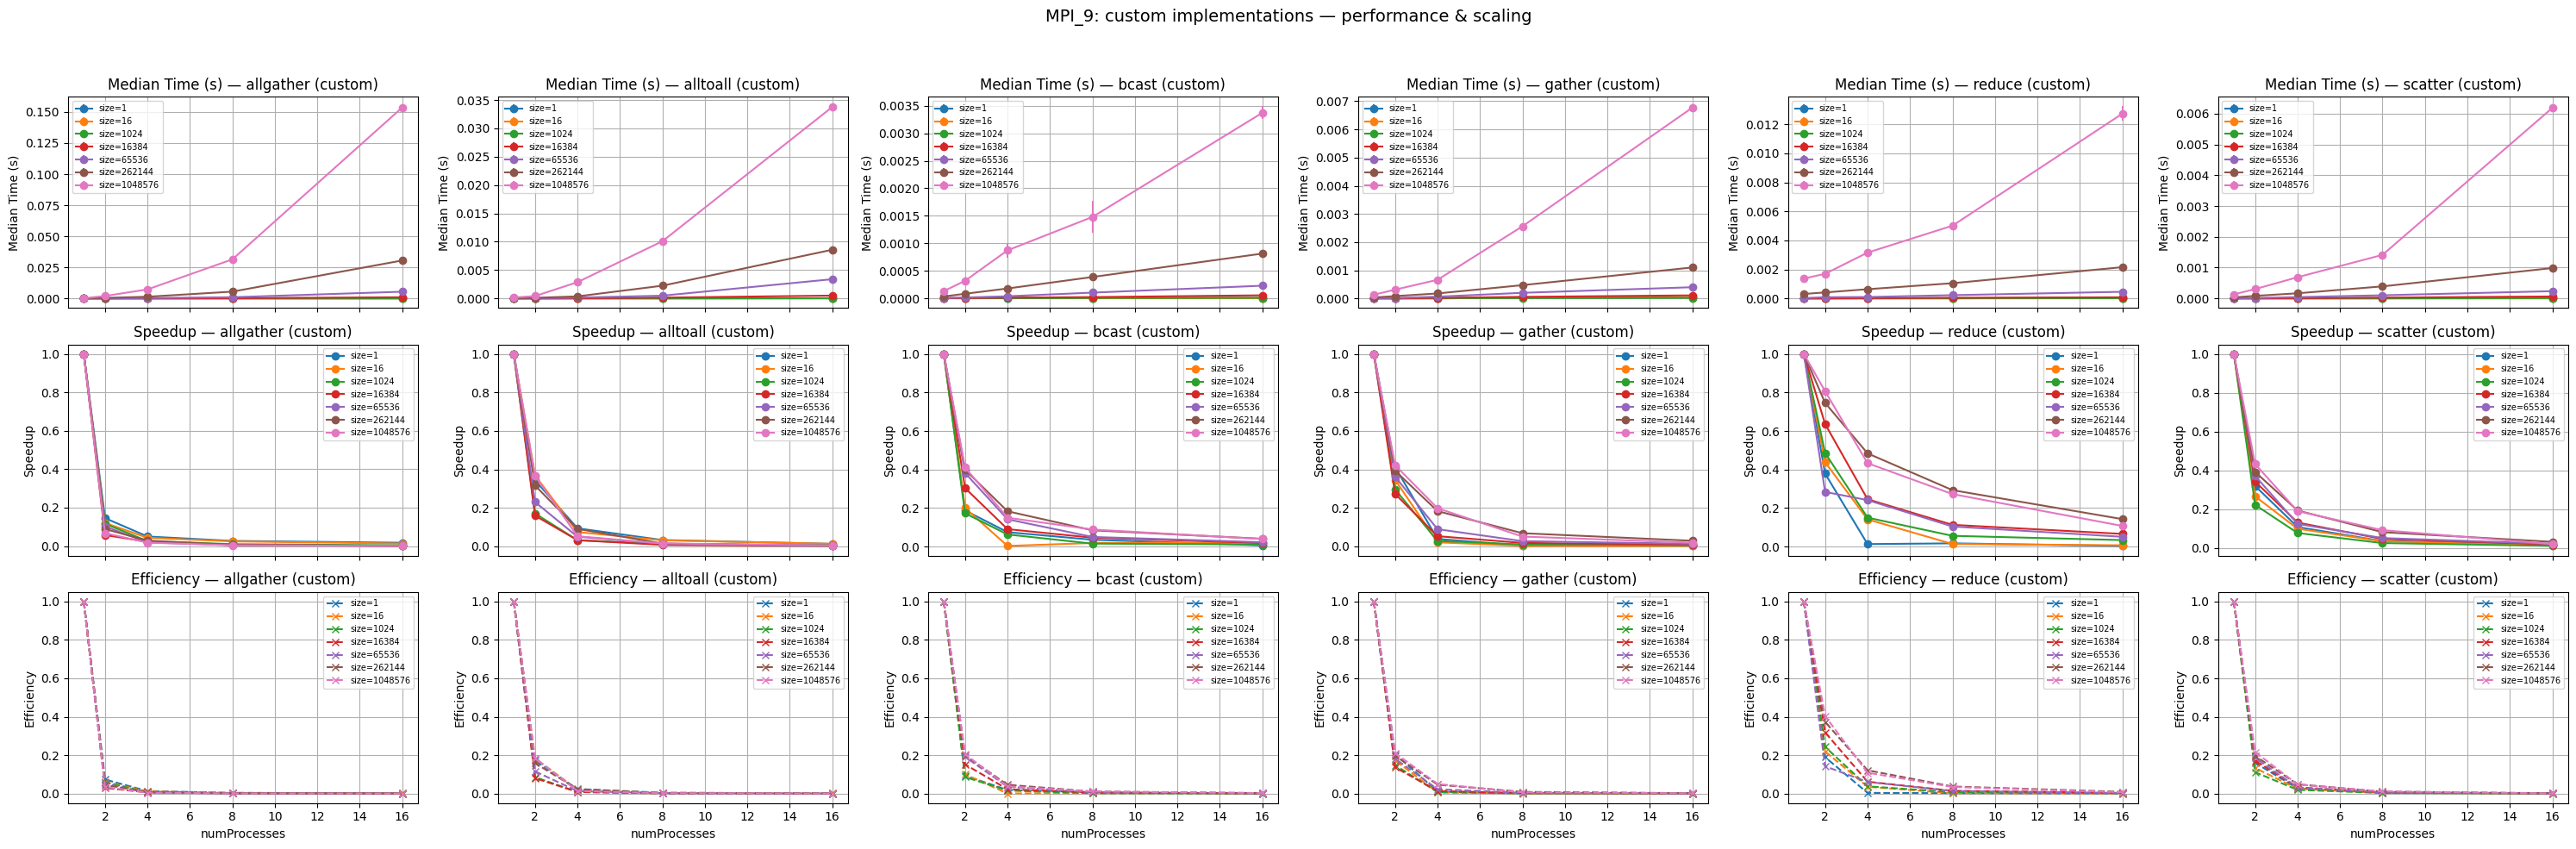

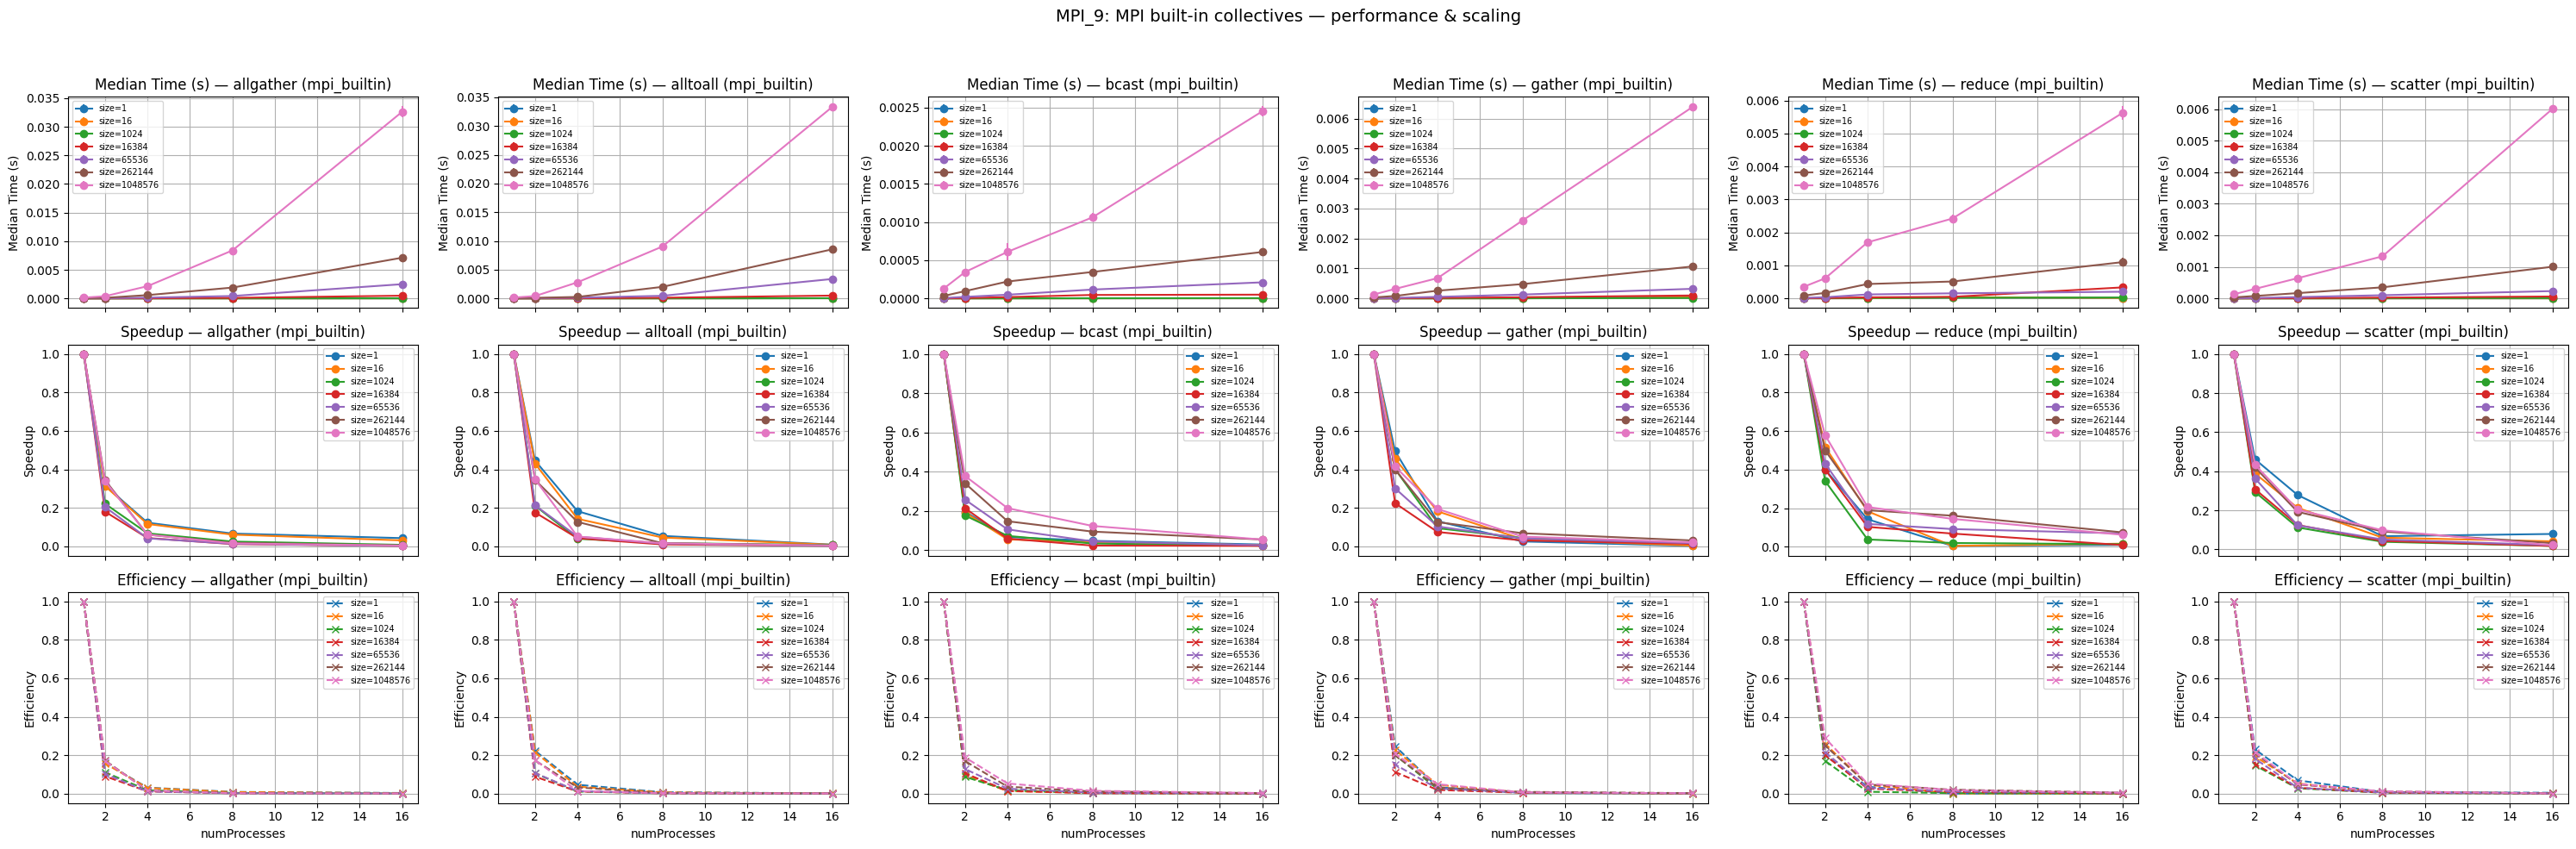

In [5]:
metrics = ["median","speedup","efficiency"]
metricLabels = {"median":"Median Time (s)","speedup":"Speedup","efficiency":"Efficiency"}
opsCustom = sorted(perfFrameCustom["opName"].unique())

fig, axes = plt.subplots(len(metrics), max(1,len(opsCustom)), figsize=(5 * max(1,len(opsCustom)), 10), sharex=True)
if len(opsCustom) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

messageSizes = sorted(perfFrameCustom["messageSizeBytes"].unique())

for colIdx, opVal in enumerate(opsCustom):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for messageSizeVal in messageSizes:
            subFrame = perfFrameCustom[(perfFrameCustom["opName"] == opVal) & (perfFrameCustom["messageSizeBytes"] == messageSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={messageSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={messageSizeVal}")
        if not anyPlotted:
            ax.text(0.5,0.5,"no data",ha='center',va='center')
        ax.set_title(f"{metricLabels[metric]} — {opVal} (custom)")
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=7)

plt.suptitle("MPI_9: custom implementations — performance & scaling", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


opsMpi = sorted(perfFrameMpi["opName"].unique())
messageSizesMpi = sorted(perfFrameMpi["messageSizeBytes"].unique())

fig, axes = plt.subplots(len(metrics), max(1,len(opsMpi)), figsize=(5 * max(1,len(opsMpi)), 10), sharex=True)
if len(opsMpi) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, opVal in enumerate(opsMpi):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for messageSizeVal in messageSizesMpi:
            subFrame = perfFrameMpi[(perfFrameMpi["opName"] == opVal) & (perfFrameMpi["messageSizeBytes"] == messageSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={messageSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={messageSizeVal}")
        if not anyPlotted:
            ax.text(0.5,0.5,"no data",ha='center',va='center')
        ax.set_title(f"{metricLabels[metric]} — {opVal} (mpi_builtin)")
        if rowIdx == len(metrics)-1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=7)

plt.suptitle("MPI_9: MPI built-in collectives — performance & scaling", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

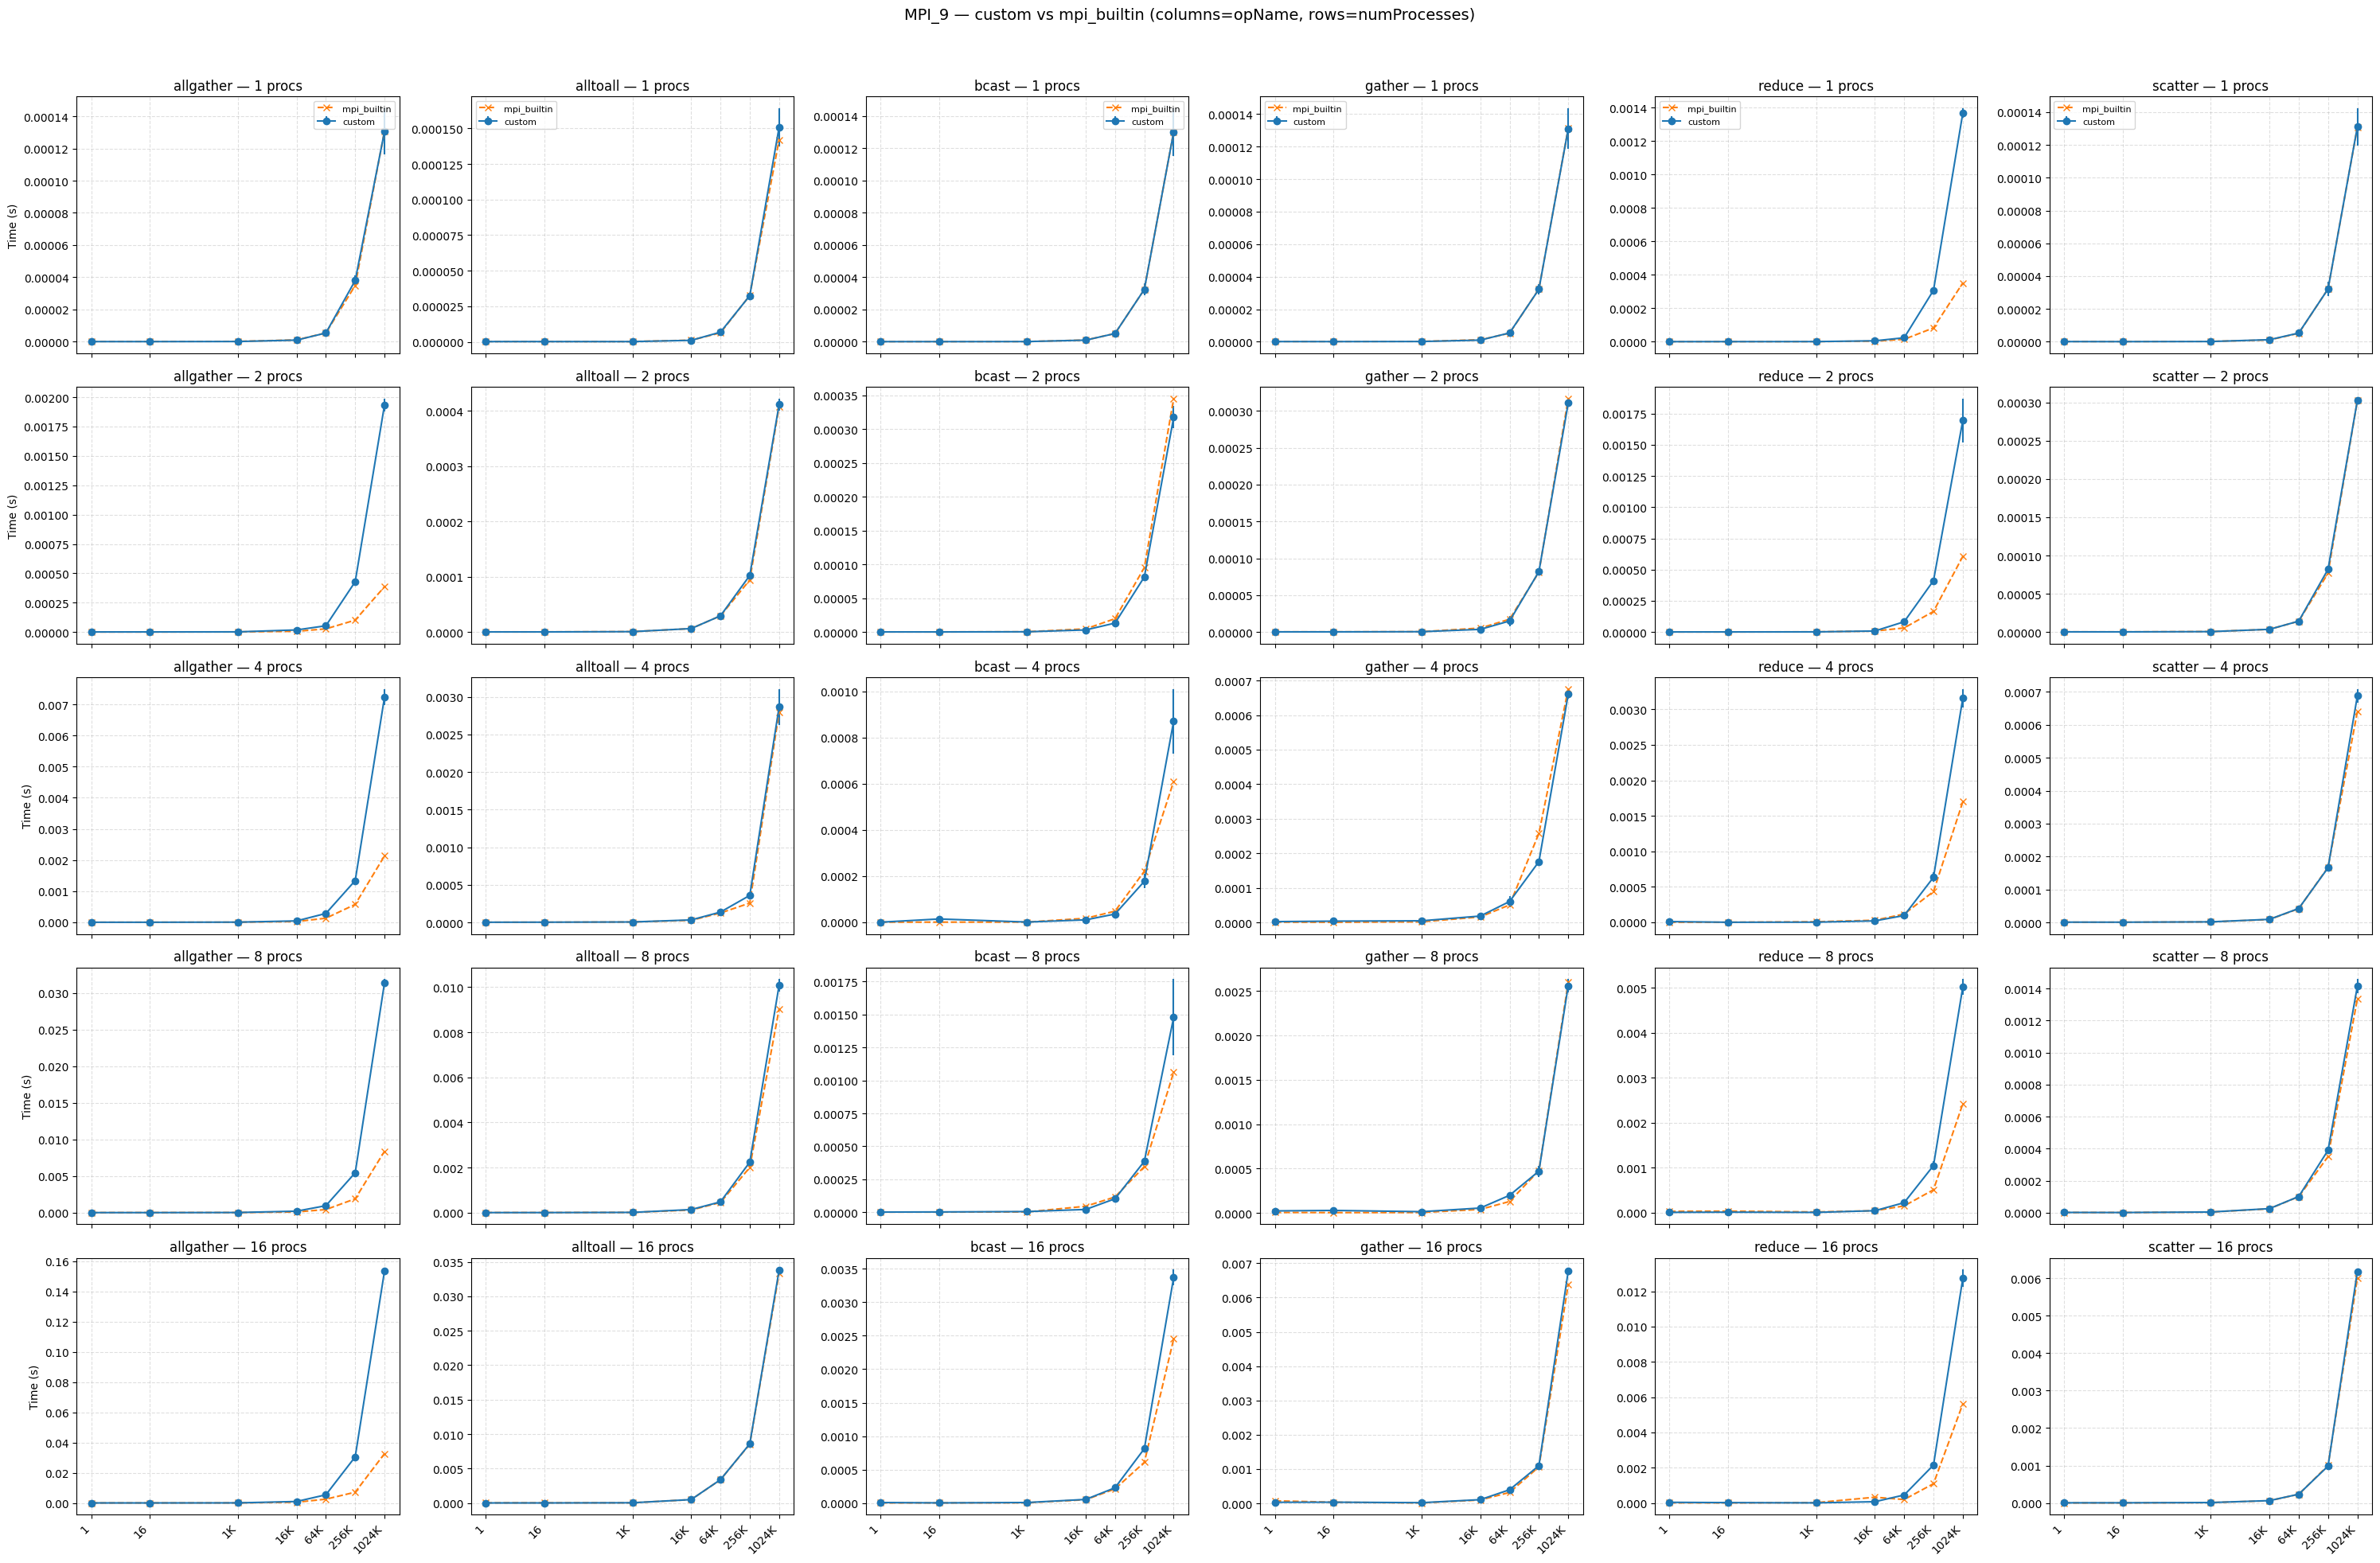

In [6]:
ops = sorted(grouped["opName"].unique())
procList = sorted(grouped["numProcesses"].unique())

numCols = max(1, len(ops))
numRows = max(1, len(procList))
fig, axes = plt.subplots(numRows, numCols, figsize=(5 * numCols, 4 * numRows), sharex='col')

if numRows == 1 and numCols == 1:
    axes2d = np.array([[axes]])
elif numRows == 1:
    axes2d = np.array([axes])
elif numCols == 1:
    axes2d = np.array([[ax] for ax in axes])
else:
    axes2d = axes

for colIdx, opVal in enumerate(ops):
    for rowIdx, p in enumerate(procList):
        ax = axes2d[rowIdx][colIdx]
        sub = grouped[(grouped["opName"] == opVal) & (grouped["numProcesses"] == p)].sort_values("messageSizeBytes")
        if sub.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
            ax.set_title(f"{opVal} — {p} procs")
            ax.grid(True)
            continue

        x = sub["messageSizeBytes"].values
        yCustom = sub["medianCustom"].values
        yMpi = sub["medianMpi"].values
        yerrCustom = sub["stdCustom"].values

        ax.set_xscale("log", base=2)
        ax.errorbar(x, yCustom, yerr=yerrCustom, marker='o', linestyle='-', label='custom')
        ax.plot(x, yMpi, marker='x', linestyle='--', label='mpi_builtin')

        ax.set_title(f"{opVal} — {p} procs")
        ax.grid(True, which='both', linestyle='--', alpha=0.4)
        if rowIdx == numRows - 1:
            xticks = x
            maxTicks = 8
            if len(xticks) > maxTicks:
                indices = np.linspace(0, len(xticks) - 1, maxTicks, dtype=int)
                xticks = [xticks[i] for i in indices]
            ax.set_xticks(xticks)
            def humanLabel(n):
                if n >= 1024:
                    if n % 1024 == 0:
                        return f"{n//1024}K"
                    return f"{n/1024:.1f}K"
                return str(n)
            ax.set_xticklabels([humanLabel(v) for v in xticks], rotation=45, ha='right')
        if colIdx == 0:
            ax.set_ylabel("Time (s)")
        if rowIdx == 0:
            ax.legend(fontsize=8)

plt.suptitle("MPI_9 — custom vs mpi_builtin (columns=opName, rows=numProcesses)", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [7]:
grouped["ratioMpiOverCustom"] = grouped["medianMpi"] / grouped["medianCustom"]
pivot = grouped.pivot_table(index=["messageSizeBytes","numProcesses"], columns="opName", values="ratioMpiOverCustom")
display(pivot.head(20))


opName                         allgather  alltoall     bcast    gather  \
messageSizeBytes numProcesses                                            
1                1              1.673469  1.333333  1.139535  1.340000   
                 2              0.771174  1.026667  1.091304  1.115226   
                 4              0.680123  0.683663  1.282007  0.399844   
                 8              0.678709  0.807987  0.852393  0.236098   
                 16             0.685689  1.963535  0.240652  2.360845   
16               1              1.744681  1.248649  1.100000  1.457831   
                 2              0.669654  1.069721  1.150000  1.108333   
                 4              0.651131  0.647837  0.056176  0.169725   
                 8              0.707478  0.855934  0.507246  0.118290   
                 16             0.749894  2.069747  0.900050  0.972289   
1024             1              1.470199  1.229885  1.040000  1.342857   
                 2              0.771957  0.995098  1.018391  0.989429   
                 4              0.565930  1.000549  0.902662  0.405356   
                 8              0.593110  0.904057  0.466115  0.321166   
                 16             0.744591  0.858399  0.500414  0.639328   
16384            1              1.103617  1.094140  1.048857  1.212702   
                 2              0.351886  0.990966  1.493695  1.474451   
                 4              0.575463  0.832176  1.624544  0.867034   
                 8              0.481494  0.851580  2.144183  0.719741   
                 16             0.503816  0.987652  0.917946  0.905694   

opName                           reduce   scatter  
messageSizeBytes numProcesses                      
1                1             1.007194  1.488889  
                 2             0.950954  1.035587  
                 4             0.090960  0.581620  
                 8             3.656481  0.804888  
                 16            0.326532  0.332744  
16               1             1.036145  1.522388  
                 2             0.875989  1.047809  
                 4             0.793367  0.714925  
                 8             2.830753  0.906802  
                 16            0.426346  0.473371  
1024             1             0.814536  1.395522  
                 2             1.159562  1.059900  
                 4             3.201431  0.971395  
                 8             2.283515  0.936607  
                 16            1.996697  0.898286  
16384            1             0.608583  0.880065  
                 2             0.966372  0.981379  
                 4             1.445807  0.929703  
                 8             1.000404  0.955487  
                 16            4.329848  0.961959